# S-NN's
The introduction notebook is quite "fat" - lots of content for general NN's and how they work, but what we want to do is start progressing towards S-NN's. Because we're speaking in broader and broader terms - we will start squashing some concepts we explicitly broke up in the previous notebook, for example when loading data in, we will transform it directly and lazily define a `Dataloader` over top of this to handle the mini-batch GD that is to come.

In [10]:
from torchvision import datasets, transforms
import torch

batch_size = 2**6

transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])


def denormalize(images):
    return transforms.ToPILImage()(images)

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, drop_last=True)

## Notes
As you can see we immediately go through the mini-batch dataloader instantiation with the MNIST's, but we also perform normalisation as in place as we load data into our runtime. It's a little more performant.

Also note;

### Normalisation (and defining our S-NN inputs)
Look how we diverge a little here with our normalization approach. We instead turn the intensity of each image pixel into a raw percentage intensity. We do this in preparation of a temporal encoding of the data... the most easy to understand encoding style would be a **rate encoding of sorts**... or explained; for each input neuron corresponding to a pixel, we'll want to convert the normalized pixel intensity to a firing rate relative to a observation window. If the intensity of a pixel is at 100% for example, we'd want the respective neuron firing every step through the observation window. Note; there are various other encodings we could experiment with. [Here is a list from ssntorch](https://snntorch.readthedocs.io/en/latest/snntorch.spikegen.html#snntorch.spikegen.rate).

# Encoding
`snntorch` provides some utilities here to visualise the encodings of images, and if you've come from `NN-introduction` you've seen traditional encodings of images. Here is what a rate encoding would look like;

Cannot view this in GitHub... sorry.


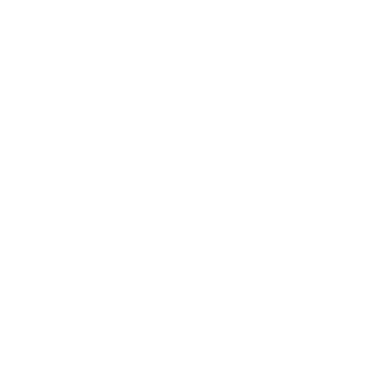

In [2]:
from snntorch import spikegen
from IPython.display import HTML
import snntorch.spikeplot as splt
import matplotlib.pyplot as plt

batches = iter(train_loader)
batch, _ = next(batches)

observation_window = 10
spike_train = spikegen.rate(batch, num_steps=observation_window)

sample = spike_train[:, 0, 0]

print("Cannot view this in GitHub... sorry.")

fig, ax = plt.subplots()
anim = splt.animator(sample, fig, ax)
HTML(anim.to_html5_video())

# Model (Replacing activation functions with LIF)
Leaky, integrate and fire neuron has the following charactersistics that correspond to each of the three parts;
- This neuron is stateful and at each step,
- The neuron **integrates** new built up input on top of it's existing state
- At each step, some of this build up is **leaked** out
- And when the neurons internal state after these two changes have happened, **fire** if the internal state built up over a threshold.

We also need to define a **observation window** which defines how many steps we should allow for this NN to express itself to the incoming **spike train**, the resulting product of a temporal encoding of the image.

## LIF challenge (or Spiking activation functions in general)
We still need to frame this as an optimisation problem that requires gradient analysis (wrt. weights) at certain points of the activation function in order to know in which way we update neuron weights. The LIF activation function has an output of $\{0, 1\}$ hence we know the evaluated derivative here of possible function change events would only occur on events $0\rightarrow0$, $0\rightarrow 1$, $1 \rightarrow 1$ and $1 \rightarrow 0$ leaving the evaluted derivative to be unhelpful; $\{0, \infty\}$.

### Surrogate Learning
Surrogate learning, [as introduced in 2019](https://arxiv.org/abs/1901.09948) effectively showcases the idea of approximating these gradient functions with smoother functions, eg. heaviside step function can be approximated with a arctan varient;

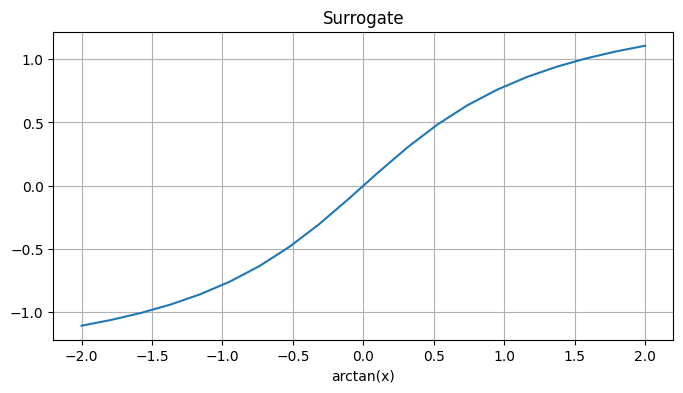

In [3]:
import matplotlib.pyplot as plt
import numpy as np


x = np.linspace(-2, 2, 20)
y = np.arctan(x)

plt.figure(figsize=(8, 4))
plt.plot(x, y)
plt.title('Surrogate')
plt.xlabel('arctan(x)')
plt.grid(True)
plt.show()

# Using `snntorch` for the simple SNN

In [12]:
import torch
import torch.nn as nn
import snntorch as snn
from snntorch import spikegen, surrogate


decay_rate = 0.9


class SimpleSNN(nn.Module):
    def __init__(self):
        super(SimpleSNN, self).__init__()

        self.fc1 = nn.Linear(28*28, 2**8)
        self.lif = snn.Leaky(
            beta=decay_rate,
            spike_grad=surrogate.atan()  # the gradient approximation function
        )
        self.fc2 = nn.Linear(2**8, 10)
        self.window = observation_window

    def forward(self, images):  # images (batch, colour_channel, height, width)
        mem = self.lif.init_leaky()

        flattened = images.view(images.size(0), -1)  # (batch, inputs)
        spike_train = spikegen.rate(flattened, num_steps=self.window)
        output_spikes = []
        for step in range(self.window):
            x = self.fc1(spike_train[step])
            x, mem = self.lif(x, mem)
            x = self.fc2(x)
            output_spikes.append(x)
        return torch.stack(output_spikes, dim=0)


model = SimpleSNN()

# Training
So with the gradient map defined via surrogates for the leaky integrate and fire neurons, we can apply a typical loss function alongside a typical optimiser and begin the process in a familiar way.

## Interpretting the final results
We will simply take the neuron that fires the most on the final layer to describe the result of the NN. Hence our `evaluate` function will need to squash via sum the results over the observation window.

Then apply a "rate decoding" of, greatest neuron firing $\implies$ indicated class.

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)


def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0

    for images, labels in loader:
        # forward pass: (observation_window, batch_size, final_layer)
        output_spikes = model(images)
        outputs = output_spikes.sum(dim=0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = (correct / total) * 100
    return accuracy

In [6]:
pre = evaluate(model, train_loader)
print(f'Accuracy before training: {pre:.2f}%')

epochs = 10

loss_history = []
accuracy_history = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.
    correct_predictions = 0
    total_predictions = 0

    for images, labels in train_loader:
        optimizer.zero_grad()

        output_spikes = model(images)
        outputs = output_spikes.sum(dim=0)
        loss = criterion(outputs, labels)  # forward pass

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = (correct_predictions / total_predictions) * 100
    loss_history.append(epoch_loss)
    accuracy_history.append(epoch_accuracy)
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

Accuracy before training: 13.13%
Epoch [1/10], Loss: 0.2997, Accuracy: 91.46%
Epoch [2/10], Loss: 0.1486, Accuracy: 95.70%
Epoch [3/10], Loss: 0.1078, Accuracy: 96.90%
Epoch [4/10], Loss: 0.0856, Accuracy: 97.55%
Epoch [5/10], Loss: 0.0705, Accuracy: 97.98%
Epoch [6/10], Loss: 0.0592, Accuracy: 98.32%
Epoch [7/10], Loss: 0.0506, Accuracy: 98.61%
Epoch [8/10], Loss: 0.0442, Accuracy: 98.81%
Epoch [9/10], Loss: 0.0389, Accuracy: 98.97%
Epoch [10/10], Loss: 0.0340, Accuracy: 99.10%


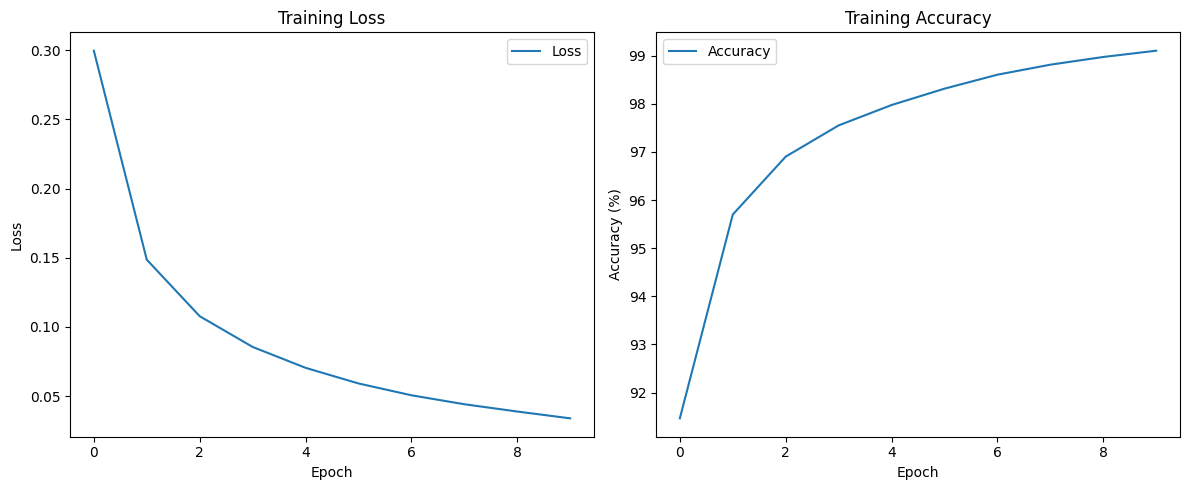

In [7]:
# Plotting the loss and accuracy curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_history, label='Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracy_history, label='Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()